# Overview

In [1]:
import simpletensor as st
import cupy as np

Successfully switched to GPU (CuPy backend)


Let's take a look at what SimpleTensor does and how to visualize the process. Let's have our tensor `a` be a 
(3, 4) tensor which ranges from 0-11 inclusive.

In [2]:
a = st.Tensor(np.arange(12).reshape((3, 4)), name="a")
a

Tensor(
[[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]],
shape=(3, 4),
name="a"
)

Now, let's say we want to create a "`loss`" tensor which simply sums the elements of `a` and multiplies by 2 (not a real loss function, but the idea is the same).

In [3]:
loss = a.sum() * 2
loss.name = "loss"
loss

Tensor(
132.0,
shape=(),
name="loss"
)

We can see the computation graph by using the `st.show_graph` function, which uses GraphViz.

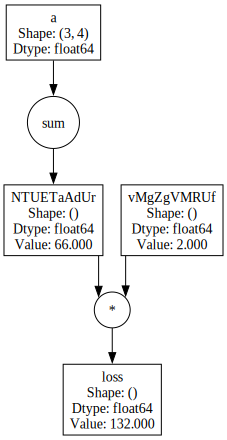

In [4]:
st.show_graph(loss)

This shows the names, shapes, and dtypes of all the tensors starting from the root tensor (in this case, `loss`). It also shows the operations which took place to create the root. In theory, we can make computation graphs as complex as we want to as long as it results in a 1 element Tensor as the root.

Note that the `2` in the *2 operation gets turned into a scalar Tensor (with a random name).

Now for the important part: the gradient. Using SimpleTensor, we can automatically calculate the gradient $\frac{\partial \text{loss}}{\partial a_{i,j}}$. Since loss is a scalar (it should be), we can calculate the matrix derivative, or Jacobian, of loss with respect to the elements of a.

In the `sum` operation, we have $\text{loss}=2\sum a_{i,j}$. If we take any derivative $\frac{\partial \text{loss}}{\partial a_{i,j}}$, we can see that it's a 2 for every element.

Let's see this automatically calculated using the `backward` function.

In [5]:
loss.backward()
print(a.grad)

[[2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]]


Let's take a look at a more complex example that has more computations.

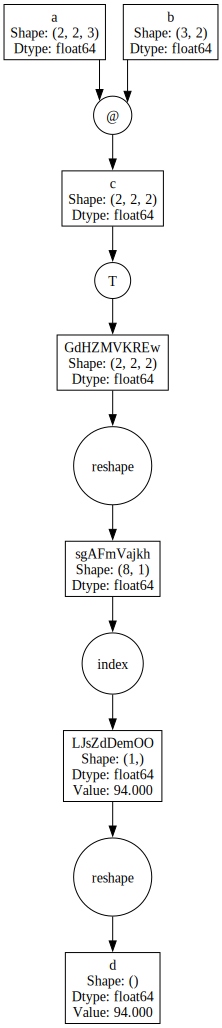

In [6]:
a = st.Tensor(np.arange(12).reshape((2, 2, 3)), name="a")
b = st.Tensor(np.arange(6).reshape((3, 2)), name="b")
c = a @ b  # Matrix multiplication notation
c.name = "c"
d = c.max()
d.name = "d"
st.show_graph(d)

This shows many features of the `Tensor` class.

1. Broadcasting. Notice that it matrix multiplied a (2, 2, 3) @ (3, 2). It actually broadcasted the (2, 2) tensor (b) to a (2, 2, 2) tensor by expanding the 0 dimension and repeating it twice, then doing a batched matrix multiply.
2. Max. We can also see that max is not a primitive function. If you take a look at the source code of our `max` implementation, you can see that it's composed of a `transpose`, `reshape`, `index`, and another `reshape` operation. The reason for this is that it's very difficult to make a differentiable max operation, since only one element per axis gets a non-zero value (the rest are 0 since the values are not used), and `np.argmax` and `cupy.argmax` only support up to 2 dimensional arrays. This makes it hard to implement without advanced indexing and without crushing the array down to 2 dimensions.
3. Custom Operations. With the implementation of max, you can see how you can implement different functions just from the base functions. For example, `softmax` is a function that is built upon the primitive functions.

Now we can call `backward` on the `d` tensor and see what we get.

In [7]:
d.backward()
print("A's gradient tensor:")
print(a.grad)
print("B's gradient tensor:")
print(b.grad)
print("C's gradient tensor:")
print(c.grad)

A's gradient tensor:
[[[0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [1. 3. 5.]]]
B's gradient tensor:
[[ 0.  9.]
 [ 0. 10.]
 [ 0. 11.]]
C's gradient tensor:
[[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 1.]]]


Now let's compare this result to PyTorch's result.

In [8]:
import torch

a = torch.tensor(np.arange(12, dtype="f").reshape((2, 2, 3)), requires_grad=True)
b = torch.tensor(np.arange(6, dtype="f").reshape((3, 2)), requires_grad=True)
c = a @ b  # Matrix multiplication notation
a.retain_grad()
b.retain_grad()
c.retain_grad()
d = c.max()

d.backward()
print("A's gradient tensor:")
print(a.grad)
print("B's gradient tensor:")
print(b.grad)
print("C's gradient tensor:")
print(c.grad)

A's gradient tensor:
tensor([[[0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [1., 3., 5.]]])
B's gradient tensor:
tensor([[ 0.,  9.],
        [ 0., 10.],
        [ 0., 11.]])
C's gradient tensor:
tensor([[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 1.]]])


As you can see, the gradients are exactly equal.

The handwritten calculation for these is too complicated to do here, but you can see how the tensor and automatic differentiation simplifies this greatly. This is the basis for why this tensor can be used in a neural network. In a forward pass, the loss tensor with shape () (scalar tensor) is calculated, and the computation graph is saved. You can then calculate the gradient of the loss w.r.t. every single trainable parameter tensor with a simple `loss.backward()` call, just like in PyTorch. This is in principle what PyTorch does, albeit much more efficient, stable, and just better.

We can see how the computation graph looks in an actual neural network by looking at the demo network. We can get the graph by running a dummy input through the network, and using the `show_graph` function on the result. Since this network is for MNIST, the dummy input will be a zeros tensor of shape (3, 1, 28, 28) where the batch size is 3, there is 1 channel (grayscale image), and the "image" is 28x28. Since this is a much larger network, it can get much harder to follow. However, this is the correct order. It starts from the top with the first convolve, and then moves down through the rest of the layers in the network graph.

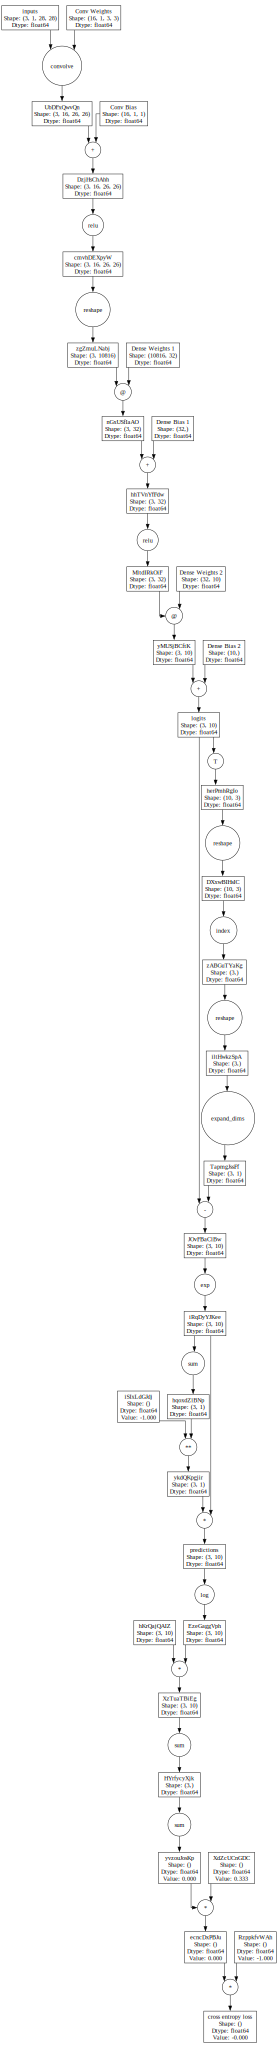

In [9]:
from simpletensor.mnist_train import Model

model = Model(dense_neurons=32, conv_filters=16, lr=0.001)

res = model(np.zeros((3, 1, 28, 28)))
res.name = "predictions"
dummy_labels = st.Tensor(np.zeros((3, 10)), name="dummy labels")
loss = st.categorical_cross_entropy(st.Tensor(np.zeros((3, 10))), res)
loss.name = "cross entropy loss"

st.show_graph(loss)